**Mount the Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports and Configs

In [2]:
!pip install keras-cv keras-core -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 57.1 MB/s eta 0:00:00


**Imports**

In [3]:
# Deafault Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv as kcv
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

Using TensorFlow backend


**Randomnes and Configurations**

In [4]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Defining Functions**

In [5]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()
def plot_confusion_matrix(model, test, test_lbls, figsize, name_jpg):
  # Compute the confusion matrix
  tp = model.predict(test, verbose=0)
  cm = confusion_matrix(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))

  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))
  precision = precision_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  recall = recall_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  f1 = f1_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(name_jpg)
  plt.show()
def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

#plot_images(IMGS[:25], LBLS[:25], 0, 5, 5)

# Test
def test_prediction(model, test, test_lbls):
  tp = model.predict(test, verbose=0)
  tp = np.argmax(tp, axis=-1)
  tgt = np.argmax(test_lbls, axis=-1)
  test_accuracy = accuracy_score(tgt, tp)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Data Initizialization

In [6]:
labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}

In [13]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = np.load('drive/MyDrive/augm_gio_split_001.npz', allow_pickle=True).values()

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = y_train_val
)

y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)
y_test = tfk.utils.to_categorical(y_test, 2)

# Get the Shape of IN OUT
input_shape = X_test.shape[1:]
output_shape = y_test.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



In [14]:
# create a dataset object for each set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

In [15]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (96, 96)

def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}


def prepare_trainset(dataset):
    return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )

def prepare_valset(dataset):
    return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

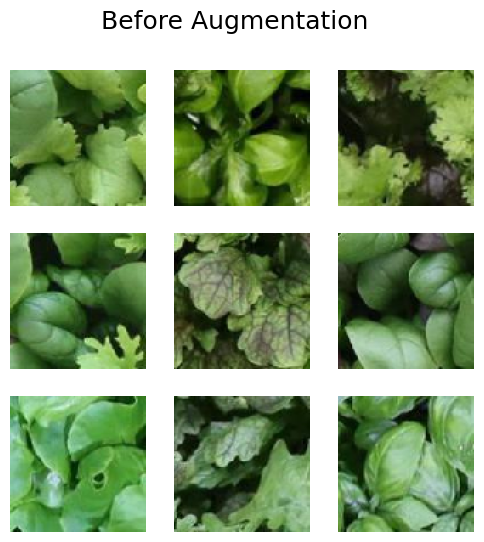

In [16]:
visualize_dataset(train_dataset, title="Before Augmentation")

**Augmentation Layers**

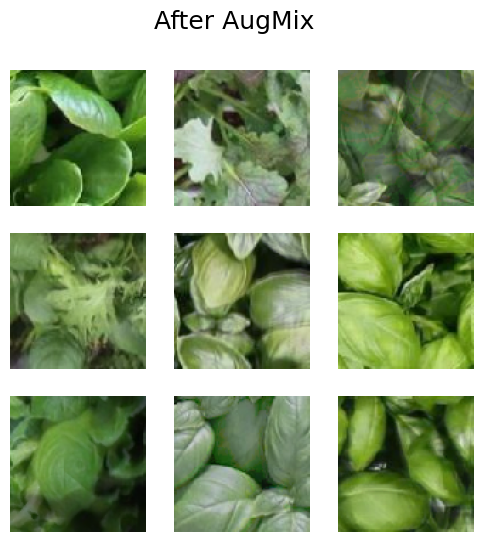

In [17]:
aug_mix = kcv.layers.AugMix([0, 255])

def apply_aug_mix(inputs):
    inputs["images"] = aug_mix(inputs["images"])
    return inputs

res = train_dataset.map(apply_aug_mix, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After AugMix")

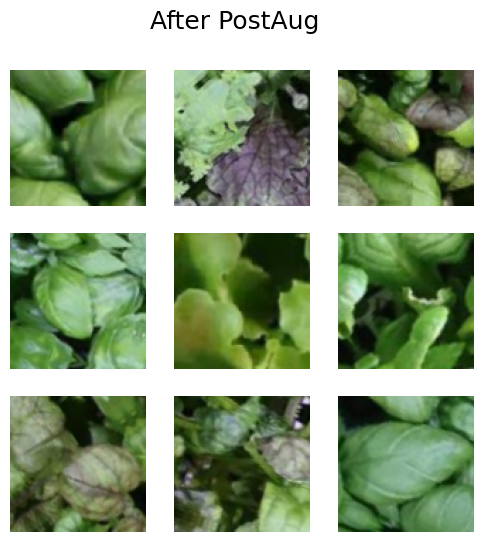

In [18]:
post_aug = tfk.Sequential([
    tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
    tkl.RandomFlip(),
    tkl.RandomRotation(factor=0.5)
])

def apply_post_aug(inputs):
    inputs["images"] = post_aug(inputs["images"])
    return inputs

res = train_dataset.map(apply_post_aug, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After PostAug")

### Training

In [19]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

train_dataset = (
    train_dataset
    .map(apply_aug_mix, num_parallel_calls=AUTOTUNE)
    #.map(apply_post_aug, num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

**Load the Model**

In [22]:
NAME_MODEL_OLD = "ConvNeXtCV_002"
!unzip drive/MyDrive/{NAME_MODEL_OLD}.zip -d ./

Archive:  drive/MyDrive/ConvNeXtCV_002.zip
   creating: ./ConvNeXtCV_002/
   creating: ./ConvNeXtCV_002/variables/
  inflating: ./ConvNeXtCV_002/variables/variables.index  
  inflating: ./ConvNeXtCV_002/variables/variables.data-00000-of-00001  
  inflating: ./ConvNeXtCV_002/saved_model.pb  
 extracting: ./ConvNeXtCV_002/fingerprint.pb  
  inflating: ./ConvNeXtCV_002/keras_metadata.pb  
   creating: ./ConvNeXtCV_002/assets/
  inflating: ./ConvNeXtCV_002_plot.png  
  inflating: ./ConvNeXtCV_002_cmatrix.png  


In [23]:
model = tfk.models.load_model(NAME_MODEL_OLD)

In [25]:
for i, layer in enumerate(model.get_layer('convnext_base').layers):
  print(i, layer)

0 <keras.src.engine.input_layer.InputLayer object at 0x7903b85d0790>
1 <keras.src.layers.preprocessing.normalization.Normalization object at 0x7903b85d0670>
2 <keras.src.engine.sequential.Sequential object at 0x7903b85d2c50>
3 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7903b85d18a0>
4 <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7903b85d2470>
5 <keras.src.layers.core.dense.Dense object at 0x7903b85d2170>
6 <keras.src.layers.core.activation.Activation object at 0x7903b85d35e0>
7 <keras.src.layers.core.dense.Dense object at 0x7903b85d25f0>
8 <keras.src.saving.legacy.saved_model.load.LayerScale object at 0x7903b85d0c40>
9 <keras.src.layers.core.activation.Activation object at 0x7903b85d0d60>
10 <keras.src.layers.core.tf_op_layer.TFOpLambda object at 0x7903b85d3af0>
11 <keras.src.layers.convolutional.conv2d.Conv2D object at 0x7903b85d3e50>
12 <keras.src.layers.normalization.layer_normalization.LayerNormalization object at 0x7903bb025f60>

In [24]:
model.get_layer('convnext_base').trainable = True

for i, layer in enumerate(model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
    metrics=['accuracy'])

**Train the Model**

In [26]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',                         # Metric to monitor (validation mean squared error in this case)
    patience=5,                                     # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.85,                                    # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',                                     # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-7                                     # Minimum learning rate
)

callbacks = [early_stopping, lr_scheduler]

history = model.fit(
    train_dataset,
    epochs = 300,
    validation_data = val_dataset,
    callbacks = callbacks
).history

Epoch 1/300
139/139 [==============================] - 143s 496ms/step - loss: 0.4788 - accuracy: 0.7847 - val_loss: 0.3347 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 2/300
139/139 [==============================] - 43s 310ms/step - loss: 0.3053 - accuracy: 0.8717 - val_loss: 0.3382 - val_accuracy: 0.8604 - lr: 0.0010
Epoch 3/300
139/139 [==============================] - 45s 316ms/step - loss: 0.2412 - accuracy: 0.8987 - val_loss: 0.2120 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 4/300
139/139 [==============================] - 43s 307ms/step - loss: 0.2151 - accuracy: 0.9129 - val_loss: 0.2749 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 5/300
139/139 [==============================] - 43s 311ms/step - loss: 0.1665 - accuracy: 0.9328 - val_loss: 0.2719 - val_accuracy: 0.9052 - lr: 0.0010
Epoch 6/300
139/139 [==============================] - 44s 318ms/step - loss: 0.1817 - accuracy: 0.9274 - val_loss: 0.2274 - val_accuracy: 0.9309 - lr: 0.0010
Epoch 7/300
139/139 [========================

### Saving and Plotting

In [27]:
NAME_MODEL = "ConvNeXtCV_002_Tuning"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Test Prediction Accuracy**

In [30]:
test_prediction(model, X_test, y_test)

ValueError: ignored

In [44]:
print(np.argmax(np.argmax(y_test, axis=1), axis=1))

[0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1
 1 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 0
 1 1 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0
 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0
 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0
 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1
 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 1
 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1
 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1
 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 1
 0 1 1 1 0 1 1 1 1 1 0 0 

Accuracy:	 0.9259
Precision:	 0.9261
Recall:		 0.9259
F1:		 0.9259


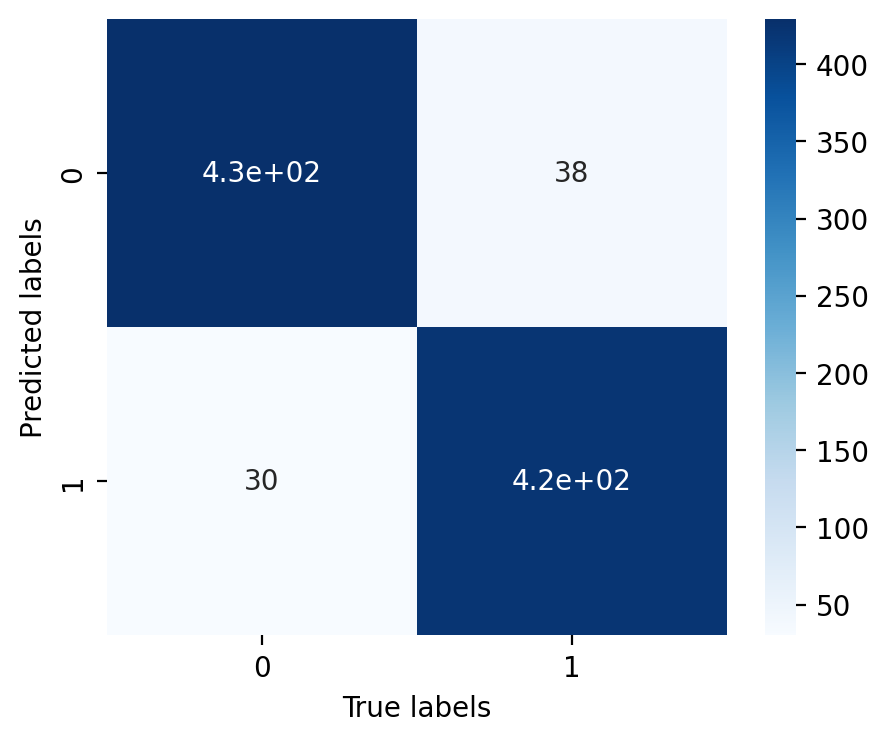

In [45]:
# Compute the confusion matrix
tp = model.predict(X_test, verbose=0)
lbls = np.argmax(np.argmax(y_test, axis=1), axis=1)
tp = np.argmax(tp, axis=-1)
cm = confusion_matrix(lbls, tp)

# Compute classification metrics
accuracy = accuracy_score(lbls, tp)
precision = precision_score(lbls, tp, average='macro')
recall = recall_score(lbls, tp, average='macro')
f1 = f1_score(lbls, tp, average='macro')

# Display the computed metrics
print('Accuracy:\t', accuracy.round(4))
print('Precision:\t', precision.round(4))
print('Recall:\t\t', recall.round(4))
print('F1:\t\t', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(5,4), dpi=200)
sns.heatmap(cm.T, annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.savefig(NAME_CMATRIX)
plt.show()

**Plots Loss**

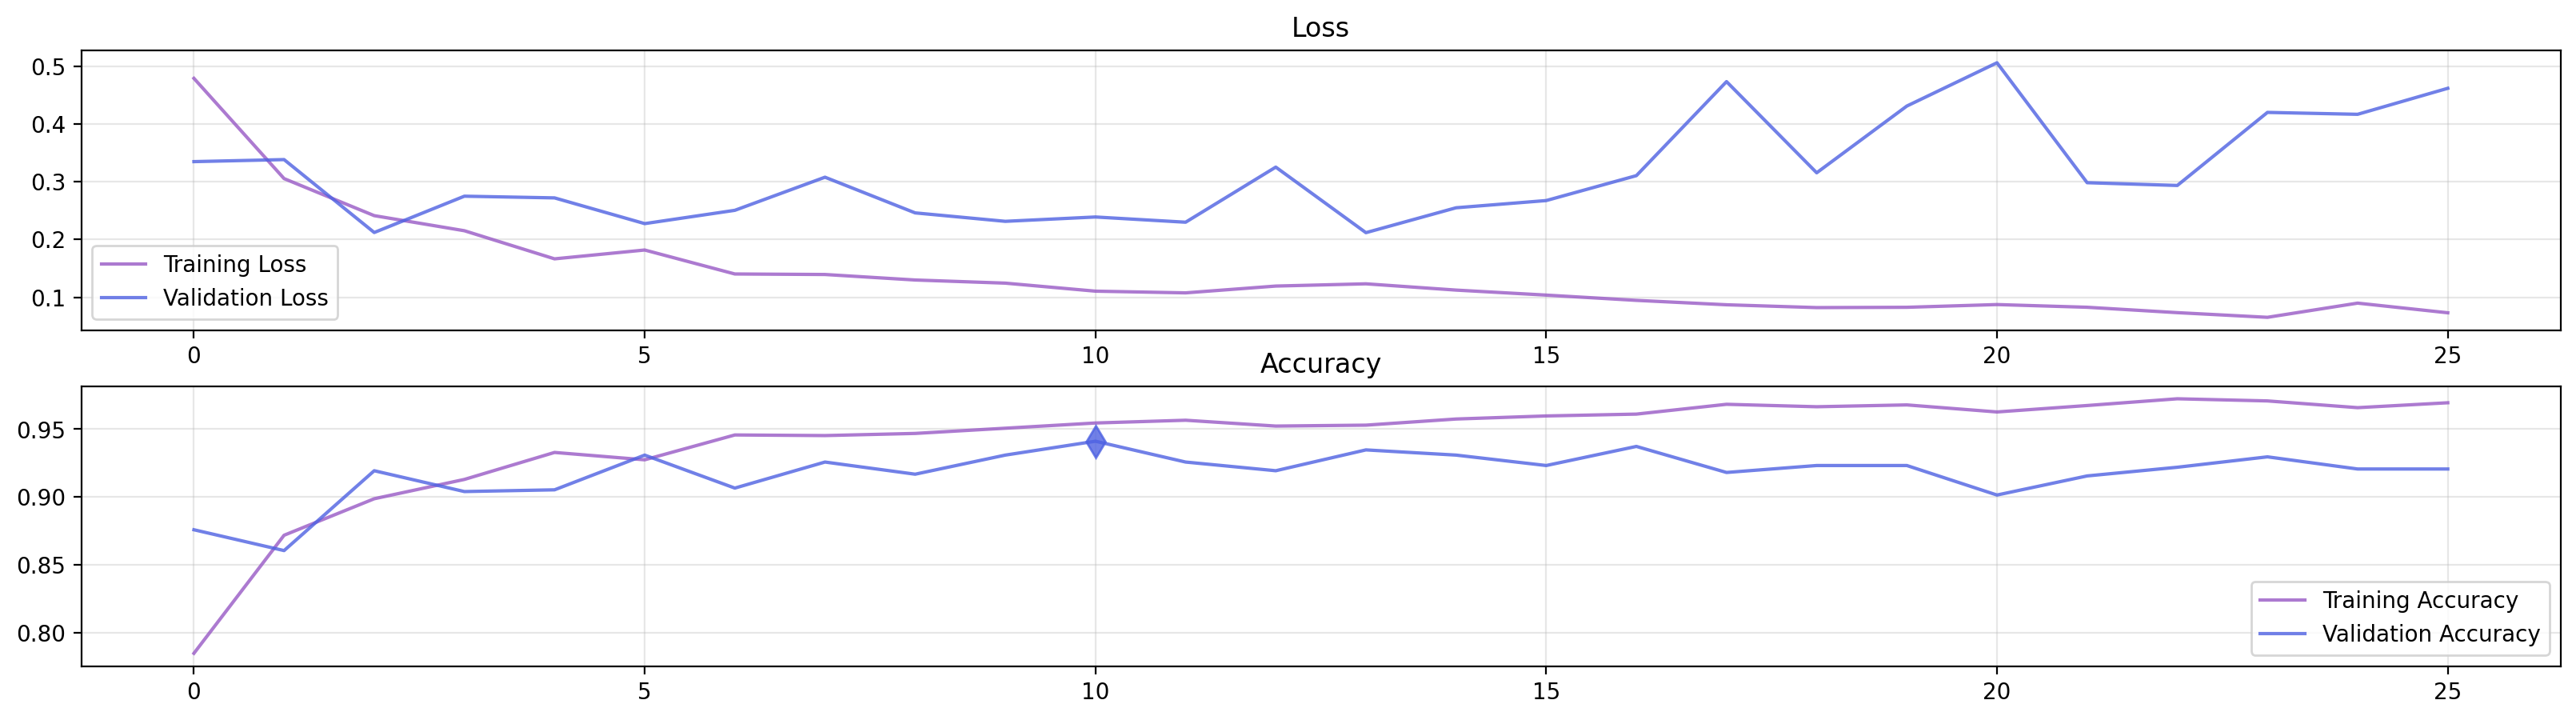

In [28]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

In [33]:
print(X_test.shape)

(918, 96, 96, 3)


In [29]:
plot_confusion_matrix(model, X_test, y_test, (5,4), NAME_CMATRIX)

ValueError: ignored

**Save the Model**

In [46]:
model.save(NAME_MODEL)

**Zip Model and Plots**

In [47]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

  adding: ConvNeXtCV_002_Tuning/ (stored 0%)
  adding: ConvNeXtCV_002_Tuning/variables/ (stored 0%)
  adding: ConvNeXtCV_002_Tuning/variables/variables.index (deflated 78%)
  adding: ConvNeXtCV_002_Tuning/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtCV_002_Tuning/saved_model.pb (deflated 92%)
  adding: ConvNeXtCV_002_Tuning/fingerprint.pb (stored 0%)
  adding: ConvNeXtCV_002_Tuning/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtCV_002_Tuning/assets/ (stored 0%)
  adding: ConvNeXtCV_002_Tuning_plot.png (deflated 12%)
  adding: ConvNeXtCV_002_Tuning_cmatrix.png (deflated 16%)


In [48]:
!cp {NAME_MODEL}.zip drive/MyDrive/

**Delete the Model**